# Meta-Embedded Clustering (MEC)

* Comparison between the darksound's features (prototypical network)
  * The features calculated with bamscape (Maad's features: shapes + centroid)
  * The features calculated with Birdnet

In [10]:
# Import the librairies
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from pathlib import Path
import shutil
import os

# Parallel processing packages
from concurrent import futures

import umap
from hdbscan.validity import validity_index
from hdbscan import HDBSCAN, all_points_membership_vectors

import torch
from torchvision import transforms
from torchvision.models import ResNet18_Weights, resnet18, VGG16_Weights, vgg16, DenseNet121_Weights, densenet121, AlexNet_Weights, alexnet
from torchvision.models.feature_extraction import create_feature_extractor

from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from kneed import KneeLocator

from darksound.dataset import Darksound, Darksound_inference
from darksound.config import load_config

from darksound.networks.protonet import PrototypicalNetworks
from darksound.networks.matchnet import MatchingNetworks
from darksound.networks.relatnet import RelationNetworks

from maad import sound
import bambird

import warnings
warnings.filterwarnings("ignore")

In [11]:
class Relation(torch.nn.Module):
    def __init__(self, backbone):
        super(Relation, self).__init__()
        self.backbone = backbone
        self.additional_layers = torch.nn.Sequential(torch.nn.AdaptiveMaxPool2d((1, 1)),torch.nn.Flatten())
    def forward(self, x):
        x = self.backbone(x)
        embedding = list(x.values())[0]
        x = self.additional_layers(embedding)
        return x

def get_features(model, spectrogram, device, params):
    # Extract the features from the model
    if params['PARAMS_MODEL']['NETWORK'] == 'relation':
        relation_features = Relation(model.backbone).to(device)
        features = relation_features(spectrogram.to(device).unsqueeze(dim=0))
    else:
        features = model.backbone.forward(spectrogram.to(device).unsqueeze(dim=0)).squeeze(dim=0)
    # Detach and convert to numpy array 
    return features.detach().cpu().numpy()

def evaluation(features, true_labels, clusterer):
    # Remove noisy samples indexes from pseudo and true labels
    pseudo_labels = clusterer.labels_
    clustered = pseudo_labels >= 0
    # Compute evaluation metrics
    ari = adjusted_rand_score(true_labels[clustered], pseudo_labels[clustered])
    ami = adjusted_mutual_info_score(true_labels[clustered], pseudo_labels[clustered])
    # sometimes the validity index can't be computed
    try :
        dbcv, dbcv_per_cluster = validity_index(
                                    X=features.astype(np.float64),
                                    labels=pseudo_labels,
                                    metric='euclidean',
                                    per_cluster_scores=True)
    except:
        dbcv = np.nan  
        dbcv_per_cluster = [np.nan]
    return ari, ami, dbcv, dbcv_per_cluster 

def get_clusterer(features, n_components, method_reduc='PCA', method_cluster='DBSCAN', random_seed = 1979) :
    if method_reduc == 'PCA':
        # Linear reduction of dimensionality of the latent space 
        pca = PCA(n_components=n_components, random_state=random_seed)
        embedding = pca.fit_transform(features)
        # Determine the parameters for DBSCAN (Sander et al., 1998, Schubert et al., 2017)
        k = embedding.shape[1] * 2 -1
    elif method_reduc == 'TSVD':  
        # Linear reduction of dimensionality of the latent space
        embedding = TruncatedSVD(n_components=n_components, random_state=random_seed).fit_transform(features)
        # Determine the parameters for DBSCAN (Sander et al., 1998, Schubert et al., 2017)
        k = embedding.shape[1] * 2 -1
    elif method_reduc == 'UMAP':
        # Nonlinear reduction of dimensionality of the latent space
        embedding = umap.UMAP(densmap=True, n_components=n_components, n_jobs=-1, random_state=random_seed).fit_transform(features)
        # Determine the parameters for DBSCAN (Sander et al., 1998, Schubert et al., 2017)
        k = embedding.shape[1] * 2 -1
    else:
        embedding = features
        k = n_components * 2 -1

    # Calculate average distance between each point in the data set and its k-nearest neighbors (k corresponds to min_points).
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(embedding)
    distances, indices = neighbors_fit.kneighbors(embedding, n_neighbors=k)
    # Sort distance values by ascending value and plot
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1] 
    # Find the knee (curvature inflexion point)
    kneedle = KneeLocator(
        x = np.arange(0, len(distances), 1),
        y = distances,
        interp_method = "polynomial",
        curve = "convex",
        direction = "increasing")
    eps = float(kneedle.knee_y)  

    if method_cluster == 'HDBSCAN':
        # Perform HDBSCAN clustering from embedding array (min_cluster_size is equivalent to min_samples in DBSCAN)
        if eps == 0 :
            clusterer = HDBSCAN(min_cluster_size=k, min_samples=k//2).fit(embedding)
            # clusterer = HDBSCAN(min_cluster_size=k, min_samples=k//4).fit(embedding)
        else:
            clusterer = HDBSCAN(min_cluster_size=k, min_samples=k//2, cluster_selection_epsilon=eps).fit(embedding)
            # clusterer = HDBSCAN(min_cluster_size=k, min_samples=k//4).fit(embedding)
    elif method_cluster == 'DBSCAN':
        # Perform DBSCAN clustering from embedding array
        clusterer = DBSCAN(min_samples=k, eps=eps).fit(embedding)

    return clusterer, embedding

def prepare_features(df_features,
                    scaler = "STANDARDSCALER",
                    features = ["shp", "centroid_f"]):
    """

    Prepare the features before clustering

    Parameters
    ----------
    df_features : pandas dataframe
        the dataframe should contain the features 
    scaler : string, optional {"STANDARDSCALER", "ROBUSTSCALER", "MINMAXSCALER"}
        Select the type of scaler uses to normalize the features.
        The default is "STANDARDSCALER".
    features : list of features, optional
        List of features will be used for the clustering. The name of the features
        should be the name of a column in the dataframe. In case of "shp", "shp"
        means that all the shpxx will be used.
        The default is ["shp","centroid_f"].

    Returns
    -------
    X : pandas dataframe
        the dataframe with the normalized features 

    """

    # select the scaler
    #----------------------------------------------
    if scaler == "STANDARDSCALER":
        scaler = StandardScaler() #
    elif scaler == "ROBUSTSCALER":
        scaler = RobustScaler()
    elif scaler == "MINMAXSCALER" :
        scaler = MinMaxScaler() 
    else :
        scaler = StandardScaler()
        print ("*** WARNING *** the scaler {} does not exist. StandarScaler was choosen".format(scaler))

    X = []
    X2 = []

    # Normalize the shapes
    #----------------------------------------------
    if "shp" in features :
        # with shapes
        # create a vector with X in order to scale all features together
        X = df_features.loc[:, df_features.columns.str.startswith("shp")]
        X_vect = X.to_numpy()
        X_shape = X_vect.shape
        X_vect = X_vect.reshape(X_vect.size, -1)
        X_vect = scaler.fit_transform(X_vect)
        X = X_vect.reshape(X_shape)
        # remove "shp" from the list
        features.remove('shp')
    
    # Normalize the other features (centroid, bandwidth...)
    #-------------------------------------------------------
    # test if the features list is not null
    if len(features) > 0 :
        # add other features like frequency centroid
        X2 = df_features[features]
        # Preprocess data : data scaler
        X2 = scaler.fit_transform(X2)

    # Concatenate the features after normalization
    #-------------------------------------------------------
    if (len(X2)>0) & (len(X)>0) :
        # create a matrix with all features after rescaling
        X = np.concatenate((X, X2), axis=1)
    elif len(X2) >0 :
        X = X2
    
    return X

def copy_matching_files(source_dir, destination_dir, pattern="*"):
    """
    Copies files matching a pattern from source directory to destination directory.

    Args:
        source_dir: Path to the source directory.
        destination_dir: Path to the destination directory.
        pattern: Glob pattern to match files (default: "*").
    """
    source_dir = Path(source_dir)
    destination_dir = Path(destination_dir)

    # Get all matching files as Path objects
    matching_files = glob(str(source_dir / pattern), recursive=True)
    matching_files = [Path(file) for file in matching_files]

    # Create destination directory if it doesn't exist
    if not destination_dir.exists():
        destination_dir.mkdir()

    # Copy each matching file
    for file in matching_files:
        relative_path = file.relative_to(source_dir)
        dest_file = destination_dir / relative_path
        dest_file.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(file, dest_file)

## Import config file and load CNN backbones

In [12]:
# path to the parent folder
parent_path = "..//darksound"

# Import config file and load parameters
params = load_config(f'{parent_path}//config.yaml')

# Name of the model
MODEL_NAME = 'prototypical-networks-5way-1shot-densenet'

# Flag to extract the features
EXTRACT_FEATURES = False

# options for the reduction and clustering methods
METHOD_REDUC = 'UMAP' 
METHOD_CLUSTER = 'HDBSCAN'


bambird.extract_rois_full_sig
The computations will be done on cpu
The backbone densenet has been loaded


## Load the Darksound dataset

In [13]:
# -------------------------------------------------------------------------
# LOAD THE CNN BACKBONE                
# -------------------------------------------------------------------------

# Set the seed for all random packages that could possibly be used
random_seed = params['RANDOM_SEED']
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Use cuda if available for faster computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'The computations will be done on {device}')

# Load the backbones and the weights
if params['PARAMS_MODEL']['BACKBONE'] == 'resnet18':
    weights = ResNet18_Weights.IMAGENET1K_V1
    model = resnet18(weights=weights).to(device)
if params['PARAMS_MODEL']['BACKBONE'] == 'vgg16':
    weights = VGG16_Weights.IMAGENET1K_V1
    model = vgg16(weights=weights).to(device)
if params['PARAMS_MODEL']['BACKBONE'] == 'densenet':
    weights = DenseNet121_Weights.IMAGENET1K_V1
    model = densenet121(weights=weights).to(device)
if params['PARAMS_MODEL']['BACKBONE'] == 'alexnet':   
    weights = AlexNet_Weights.IMAGENET1K_V1
    model = alexnet(weights=weights).to(device)

print(f'The backbone {params["PARAMS_MODEL"]["BACKBONE"]} has been loaded')

# -------------------------------------------------------------------------
# LOAD THE Darksound DATASET                
# -------------------------------------------------------------------------
# Load the Darksound dataset
test_set = Darksound(
                    root=parent_path,
                    split='test', 
                    hpss=params['PARAMS_MODEL']['HPSS'], 
                    remove_background=params['PARAMS_MODEL']['REMOVE_BG'], 
                    transform=transforms.Compose([weights.transforms()]),
                    n_classes=30,
                    download=False,
                    )
# Get the ground truth labels
true_labels = np.array(test_set.__getlabel__())


bambird.extract_rois_full_sig


## Extract features from the CNN backbone

In [14]:
if EXTRACT_FEATURES == True:

    # Get features shape and flatten classifier or fully connected layers
    if params['PARAMS_MODEL']['BACKBONE'] == 'resnet18':
        features = np.zeros(shape=(len(test_set), model.fc.in_features))
        model.fc = torch.nn.Flatten()
    elif params['PARAMS_MODEL']['BACKBONE'] == 'vgg16':
        features = np.zeros(shape=(len(test_set), 512))
        # Reduce vector size and computation in the network
        model.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        model.classifier = torch.nn.Flatten()
    elif params['PARAMS_MODEL']['BACKBONE'] == 'densenet':
        features = np.zeros(shape=(len(test_set), model.classifier.in_features))
        model.classifier = torch.nn.Flatten()
    elif params['PARAMS_MODEL']['BACKBONE'] == 'alexnet':
        features = np.zeros(shape=(len(test_set), 256))
        # Reduce vector size and computation in the network
        model.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        model.classifier = torch.nn.Flatten()
        
    # Load the meta-learning algorithms
    if params['PARAMS_MODEL']['NETWORK'] == 'matching':
        model = MatchingNetworks(model, use_softmax=True).to(device)
    if params['PARAMS_MODEL']['NETWORK'] == 'prototypical':
        model = PrototypicalNetworks(model, use_softmax=True).to(device)
    if params['PARAMS_MODEL']['NETWORK'] == 'relation':
        if params['PARAMS_MODEL']['BACKBONE'] == 'resnet18':
            model = create_feature_extractor(model, return_nodes=['layer4.1.bn2']) 
        if params['PARAMS_MODEL']['BACKBONE'] == 'vgg16':
            model = create_feature_extractor(model, return_nodes=['features.30'])
        if params['PARAMS_MODEL']['BACKBONE'] == 'densenet':
            model = create_feature_extractor(model, return_nodes=['features.norm5'])
        if params['PARAMS_MODEL']['BACKBONE'] == 'alexnet':
            model = create_feature_extractor(model, return_nodes=['features.12'])  
        model = RelationNetworks(model, use_softmax=False).to(device)


    # Load pretrained model fine-tuned on pseudo labeled set
    model.load_state_dict(
        torch.load(
            f'{parent_path}//embeddings//{MODEL_NAME}.pt', 
            map_location=device
            )
        ) 

    # Inference mode to extract features
    for i in tqdm(range(len(test_set)), desc='Extracting features'):
        # Extracting features from the model
        features[i] = get_features(model, test_set[i][0], device, params) 

    # Save the vector embeddings to disk
    np.save(f'{parent_path}//embeddings//features//{MODEL_NAME}-30classes.npy', features)

Extracting features: 100%|██████████| 8163/8163 [12:00<00:00, 11.33it/s]


## Extract features from bamscape

In [41]:
if EXTRACT_FEATURES == True:

        # Compute features for each ROIS
        # -------------------------------

        # compute the features on the full dataset
        df_features, csv_features = bambird.multicpu_compute_features(
                        dataset     = f'{parent_path}//data//test',
                        params      = params['PARAMS_FEATURES'],
                        overwrite   = True,
                        verbose     = True)

        features = prepare_features(df_features, 
                scaler = "MINMAXSCALER", 
                features = ['shp', 'centroid_f', 'peak_f'])

        FEATURES_FILENAME = (
                'features_'
                + params["PARAMS_FEATURES"]["SHAPE_RES"]
                + "_NFFT"
                + str(params["PARAMS_FEATURES"]["NFFT"])
                + "_SR"
                + str(params["PARAMS_FEATURES"]["SAMPLE_RATE"])
                )

        # Save the vector embeddings to disk
        np.save(f'{parent_path}//embeddings//features//{FEATURES_FILENAME}.npy', features)



====================== COMPUTE FEATURES ======================

*******************************************************
number of files : 8163
number of categories : 30
unique categories : ['Chordeiles acutipennis_Lesser Nighthawk'
 'Crypturellus soui_Little Tinamou'
 'Nyctibius leucopterus_White-winged Potoo'
 'Nyctibius griseus_Common Potoo' 'Strix huhula_Black-banded Owl'
 'Hydropsalis cayennensis_White-tailed Nightjar'
 'Hydropsalis climacocerca_Ladder-tailed Nightjar'
 'Nyctiprogne leucopyga_Band-tailed Nighthawk'
 'Lurocalis semitorquatus_Short-tailed Nighthawk'
 'Chordeiles nacunda_Nacunda Nighthawk'
 'Megascops watsonii_Tawny-bellied Screech Owl'
 'Glaucidium hardyi_Amazonian Pygmy Owl' 'Lophostrix cristata_Crested Owl'
 'Nyctipolus nigrescens_Blackish Nightjar'
 'Micrastur semitorquatus_Collared Forest Falcon'
 'Crypturellus variegatus_Variegated Tinamou'
 'Crypturellus brevirostris_Rusty Tinamou' 'Tinamus major_Great Tinamou'
 'Micrastur gilvicollis_Lined Forest Falcon'
 'M

## Extract features from BirdNet

In [42]:
if EXTRACT_FEATURES == True:

    # if the directory birdnet does not exist, create it
    if not os.path.exists(f'{parent_path}//birdnet'):
        # copy the wav files in test directory keeping the same folder and subfolders 
        copy_matching_files(f'{parent_path}//data', f'{parent_path}//birdnet', pattern="**/*.wav")

    # Get the list of paths to the audio files
    list_paths = glob(f'{parent_path}//birdnet//**/*.wav', recursive=True)

    # load the audio files and add 3s of silence at the end
    for path in list_paths:
        audio, fs = sound.load(path)
        # test if the audio is less than 3s
        if len(audio) < 3*fs:
            # trim the audio to 3s
            audio = sound.trim(s=audio, fs=fs, min_t=0, max_t=3, pad=True, pad_constant=0)
            # save the audio
            sound.write(filename=path, fs=fs, data=audio, bit_depth=16)


In [ ]:
# birdnet packages
from birdnetlib.analyzer import Analyzer
from birdnetlib import Recording

# Load and initialize the BirdNET-Analyzer models.
analyzer = Analyzer()

# do the analysis
def single_analysis(path):

    recording = Recording(
        analyzer,
        path,
        min_conf=0.1,

    )
    recording.analyze()
    detections = recording.detections
    recording.extract_embeddings()
    list_embeddings = recording.embeddings

    if len(recording.chunks) == 0:
        detections = {
                    'path':path,
                    'label':'no detection', 
                    'confidence':0,
                    'embeddings': np.zeros(1024)}
    else :
        try :
            # ***** detections *****
            # convert dictionalry to pandas dataframe
            df = pd.DataFrame(detections)
            # pivot the dataframe
            df_pivot = df.pivot(index='label', columns='start_time', values='confidence')
            # replace Nan by 0
            df_pivot = df_pivot.fillna(0)
            # add a column with the average of the confidence.
            df_pivot['mean'] = df_pivot.mean(axis=1)
            # Get the label with the highest mean confidence
            label = df_pivot['mean'].idxmax()
            # Get the highest mean confidence
            confidence = df_pivot['mean'].max()

            # ***** embeddings *****
            embeddings = np.zeros(1024)
            for ii, emb in enumerate(list_embeddings):
                embeddings += emb['embeddings']
            # do the average
            embeddings = embeddings / (ii+1)

            # **** dictionary ****
            detections = {
                'path':path,
                'label':label, 
                'confidence':confidence,
                'embeddings':[embeddings]}
        except:
            detections = {
                    'path':path,
                    'label':'no detection', 
                    'confidence':0,
                    'embeddings': np.zeros(1024)}

    return detections

# do multi-cpu analysis of the audio files using the function single_analysis

# Get the list of paths to the audio files
list_paths = glob(f'{parent_path}//birdnet//**/*.wav', recursive=True)

# create an empty dataframe. It will contain all ROIs found for each
# audio file in the directory
all_detections = []

# Number of CPU used for the calculation.
nb_cpu = os.cpu_count()

# Multicpu process
with tqdm(total=len(list_paths), desc="multi cpu indices calculation...") as pbar:
    with futures.ProcessPoolExecutor(max_workers=nb_cpu) as pool:
        # give the function to map on several CPUs as well its arguments as
        # as list
        for detections in pool.map(single_analysis, list_paths):
            pbar.update(1)
            # concatenate the dictionary detections with the dictionary all_detections
            all_detections.append(dict(detections))

Transform the detection and save the embeddings and the true labels associated 

In [45]:
df = pd.DataFrame(all_detections)

# remove rows with no detection
df = df[df['label'] != 'no detection']

# add a column with the file name
df['file'] = df['path'].apply(lambda x: x.split('/')[-1])

display(df)

# Get the tuple with the filename and the true label
filename_truelabels = test_set._flat_species_files

# convert filename_truelabels to a dictionary with the key as the filename and the value as the true label
filename_truelabels = {k.split('/')[-1]:v for k,v in filename_truelabels}

# add a column with the true label of the file
df['true_label'] = df['file'].apply(lambda x: filename_truelabels[x])

# convert features into a numpy array
df['embeddings'] = df['embeddings'].apply(lambda x: x[0])
features = np.array([x for x in df['embeddings']])
# convert the true labels into a numpy array
true_labels_birdnet = np.array([x for x in df['true_label']])

# Save the vector embeddings and the true label to disk
np.save(f'{parent_path}//embeddings//features//birdnet.npy', features)
np.save(f'{parent_path}//embeddings//features//birdnet_truelabel.npy', true_labels_birdnet)

,path,label,confidence,embeddings,file
1,..//darksound//birdnet/test/Chordeiles acutipe...,Chordeiles acutipennis_Lesser Nighthawk,0.859327,"[[0.0, 0.0, 0.0, 0.0, 0.6444503863652548, 1.58...",XC275863_50s_00.wav
2,..//darksound//birdnet/test/Chordeiles acutipe...,Chordeiles acutipennis_Lesser Nighthawk,0.995151,"[[0.0, 0.022210082039237022, 0.0, 0.0, 0.69839...",XC257766_0s_00.wav
3,..//darksound//birdnet/test/Chordeiles acutipe...,Chordeiles acutipennis_Lesser Nighthawk,0.857759,"[[0.0, 0.0, 0.0, 0.0, 0.6147228678067526, 1.54...",XC275863_10s_00.wav
4,..//darksound//birdnet/test/Chordeiles acutipe...,Chordeiles acutipennis_Lesser Nighthawk,0.591372,"[[0.5309928357601166, 0.000692420561487476, 0....",XC345024_20s_00.wav
5,..//darksound//birdnet/test/Chordeiles acutipe...,Chordeiles acutipennis_Lesser Nighthawk,0.986557,"[[0.021620938554406166, 0.06270607560873032, 0...",XC275863_40s_01.wav
...,...,...,...,...,...
8158,..//darksound//birdnet/test/Nyctibius bracteat...,Nyctibius bracteatus_Rufous Potoo,0.930393,"[[1.4521126747131348, 0.1784660369157791, 0.21...",XC12053_0s_00.wav
8159,..//darksound//birdnet/test/Nyctibius bracteat...,Nyctibius bracteatus_Rufous Potoo,0.919434,"[[0.8704969882965088, 0.0, 0.34910693764686584...",XC251260_30s_00.wav
8160,..//darksound//birdnet/test/Nyctibius bracteat...,Megascops albogularis_White-throated Screech-Owl,0.163333,"[[0.7620883584022522, 0.0, 0.04001429677009582...",XC226738_20s_00.wav
8161,..//darksound//birdnet/test/Nyctibius bracteat...,Nyctibius bracteatus_Rufous Potoo,0.856397,"[[1.0099045038223267, 0.0, 0.18179796636104584...",XC251260_0s_00.wav


## Dimensionality reduction and clustering

In [46]:
# # ********** Darksound n_components=25 ************
features = np.load(f'{parent_path}//embeddings//features//{MODEL_NAME}-30classes.npy')
range_n_components = [5,10,15,20,25,30,35,40,45,50]

for n_components in range_n_components:

    clusterer, embedding = get_clusterer(
                                features=features, 
                                n_components= n_components, 
                                method_reduc=METHOD_REDUC, 
                                method_cluster=METHOD_CLUSTER, 
                                random_seed = random_seed)

    # Get the predicted labels and the number of clusters
    pseudo_labels = clusterer.labels_ 
    clusters = len(np.unique(pseudo_labels[pseudo_labels >= 0])) # remove noisy samples
    percentage = int(round(np.sum(pseudo_labels >= 0) / features.shape[0], 2) * 100)
    print(f'\nClustering {percentage}% of the data: Found {clusters} clusters with n_components={n_components}.')

    ari, ami, dbcv, dbcv_per_cluster = evaluation(embedding, true_labels, clusterer)
    print(f'ARI: {ari}\nAMI: {ami}\nDBCV: {dbcv}\nDBCV_avg: {np.mean(dbcv_per_cluster)}\n')

# ********** MAAD => n_components=20 ************
# load the features from maad
features = np.load(f'{parent_path}//embeddings//features//{FEATURES_FILENAME}.npy')

range_n_components = [5,10,15,20,25,30,35,40,45,50]

for n_components in range_n_components:

    clusterer, embedding = get_clusterer(
                                features=features, 
                                n_components= n_components, 
                                method_reduc=METHOD_REDUC, 
                                method_cluster=METHOD_CLUSTER, 
                                random_seed = random_seed)

    # Get the predicted labels and the number of clusters
    pseudo_labels = clusterer.labels_ 
    clusters = len(np.unique(pseudo_labels[pseudo_labels >= 0])) # remove noisy samples
    percentage = int(round(np.sum(pseudo_labels >= 0) / features.shape[0], 2) * 100)
    print(f'\nClustering {percentage}% of the data: Found {clusters} clusters with n_components={n_components}.')

    ari, ami, dbcv, dbcv_per_cluster = evaluation(embedding, true_labels, clusterer)
    print(f'ARI: {ari}\nAMI: {ami}\nDBCV: {dbcv}\nDBCV_avg: {np.mean(dbcv_per_cluster)}\n')

# ********** BIRDNET => n_components=25 ************
# load the features from birdnet
features = np.load(f'{parent_path}//embeddings//features//birdnet.npy')
# separate the features from the true labels
true_labels_birdnet = np.load(f'{parent_path}//embeddings//features//birdnet_truelabel.npy')

range_n_components = [5,10,15,20,25,30,35,40,45,50]

for n_components in range_n_components:

    clusterer, embedding = get_clusterer(
                                features=features, 
                                n_components= n_components, 
                                method_reduc=METHOD_REDUC, 
                                method_cluster=METHOD_CLUSTER, 
                                random_seed = random_seed)

    # Get the predicted labels and the number of clusters
    pseudo_labels = clusterer.labels_ 
    clusters = len(np.unique(pseudo_labels[pseudo_labels >= 0])) # remove noisy samples
    percentage = int(round(np.sum(pseudo_labels >= 0) / features.shape[0], 2) * 100)
    print(f'\nClustering {percentage}% of the data: Found {clusters} clusters with n_components={n_components}.')

    ari, ami, dbcv, dbcv_per_cluster = evaluation(embedding, true_labels_birdnet, clusterer)
    print(f'ARI: {ari}\nAMI: {ami}\nDBCV: {dbcv}\nDBCV_avg: {np.mean(dbcv_per_cluster)}\n')


Clustering 72% of the data: Found 492 clusters with n_components=5.
ARI: 0.24151520891497513
AMI: 0.5573792303359617
DBCV: 0.24698159452955226
DBCV_avg: 0.4357030847318303


Clustering 65% of the data: Found 178 clusters with n_components=10.
ARI: 0.3748299672311346
AMI: 0.6689525740473163
DBCV: 0.17705775237707672
DBCV_avg: 0.3825007709938651


Clustering 72% of the data: Found 84 clusters with n_components=15.
ARI: 0.49100545944775176
AMI: 0.7239063294590616
DBCV: 0.13608472553380463
DBCV_avg: 0.40844590474497827


Clustering 78% of the data: Found 48 clusters with n_components=20.
ARI: 0.6490294912122855
AMI: 0.7917094869784826
DBCV: 0.342726769079183
DBCV_avg: 0.3921753703925974


Clustering 74% of the data: Found 41 clusters with n_components=25.
ARI: 0.6633885752000827
AMI: 0.797990748515717
DBCV: 0.35277391015581167
DBCV_avg: 0.4384865194426136


Clustering 76% of the data: Found 34 clusters with n_components=30.
ARI: 0.6492865591932818
AMI: 0.7941519148344847
DBCV: 0.300045674

## Plot the vector embeddings in two dimensions

Create a random colormap

Number of labels: 25


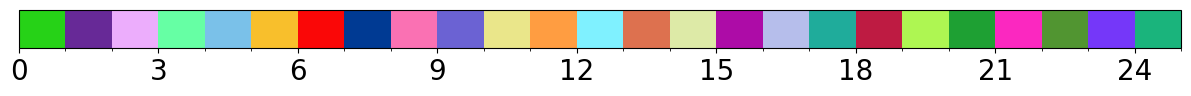

In [120]:
def rand_cmap(nlabels, first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map based on HLS
    randHLScolors = [(i / 180.,
                    (25 + 50 * np.random.rand() +  np.random.rand()*10) / 100.,
                    (50 + 50 * np.random.rand() +  np.random.rand()*10) / 100.) for i in np.arange(0., 180., 180. / nlabels)]

    # Convert HLS list to RGB
    randRGBcolors = []
    for HLScolor in randHLScolors:
        randRGBcolors.append(colorsys.hls_to_rgb(HLScolor[0], HLScolor[1], HLScolor[2]))

    if first_color_black:
        randRGBcolors[0] = [0, 0, 0]

    if last_color_black:
        randRGBcolors[-1] = [0, 0, 0]

    random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # shuffle a colormap matplotlib object
    indices = np.linspace(0, 1, nlabels)
    np.random.shuffle(indices)
    colors = random_colormap(indices)

    random_colormap = LinearSegmentedColormap.from_list('new_map', colors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

def plot_embedding(features_path, n_components=10, method_reduc='UMAP', method_cluster='DBSCAN', random_seed=1979):
    features = np.load(features_path)
    clusterer, embedding = get_clusterer(
                        features=features, 
                        n_components= n_components, 
                        method_reduc=method_reduc, 
                        method_cluster=method_cluster, 
                        random_seed = random_seed)
    # Get the predicted labels and the number of clusters
    labels = clusterer.labels_ 
    # Reduce dimensionality
    reduced_embedding = umap.UMAP(n_jobs=-1, n_components=2, random_state=random_seed).fit_transform(features)
    
    return labels, reduced_embedding 

new_cmap = rand_cmap(25, first_color_black=False, last_color_black=False, verbose=True)

Load the vector embeddings and plot

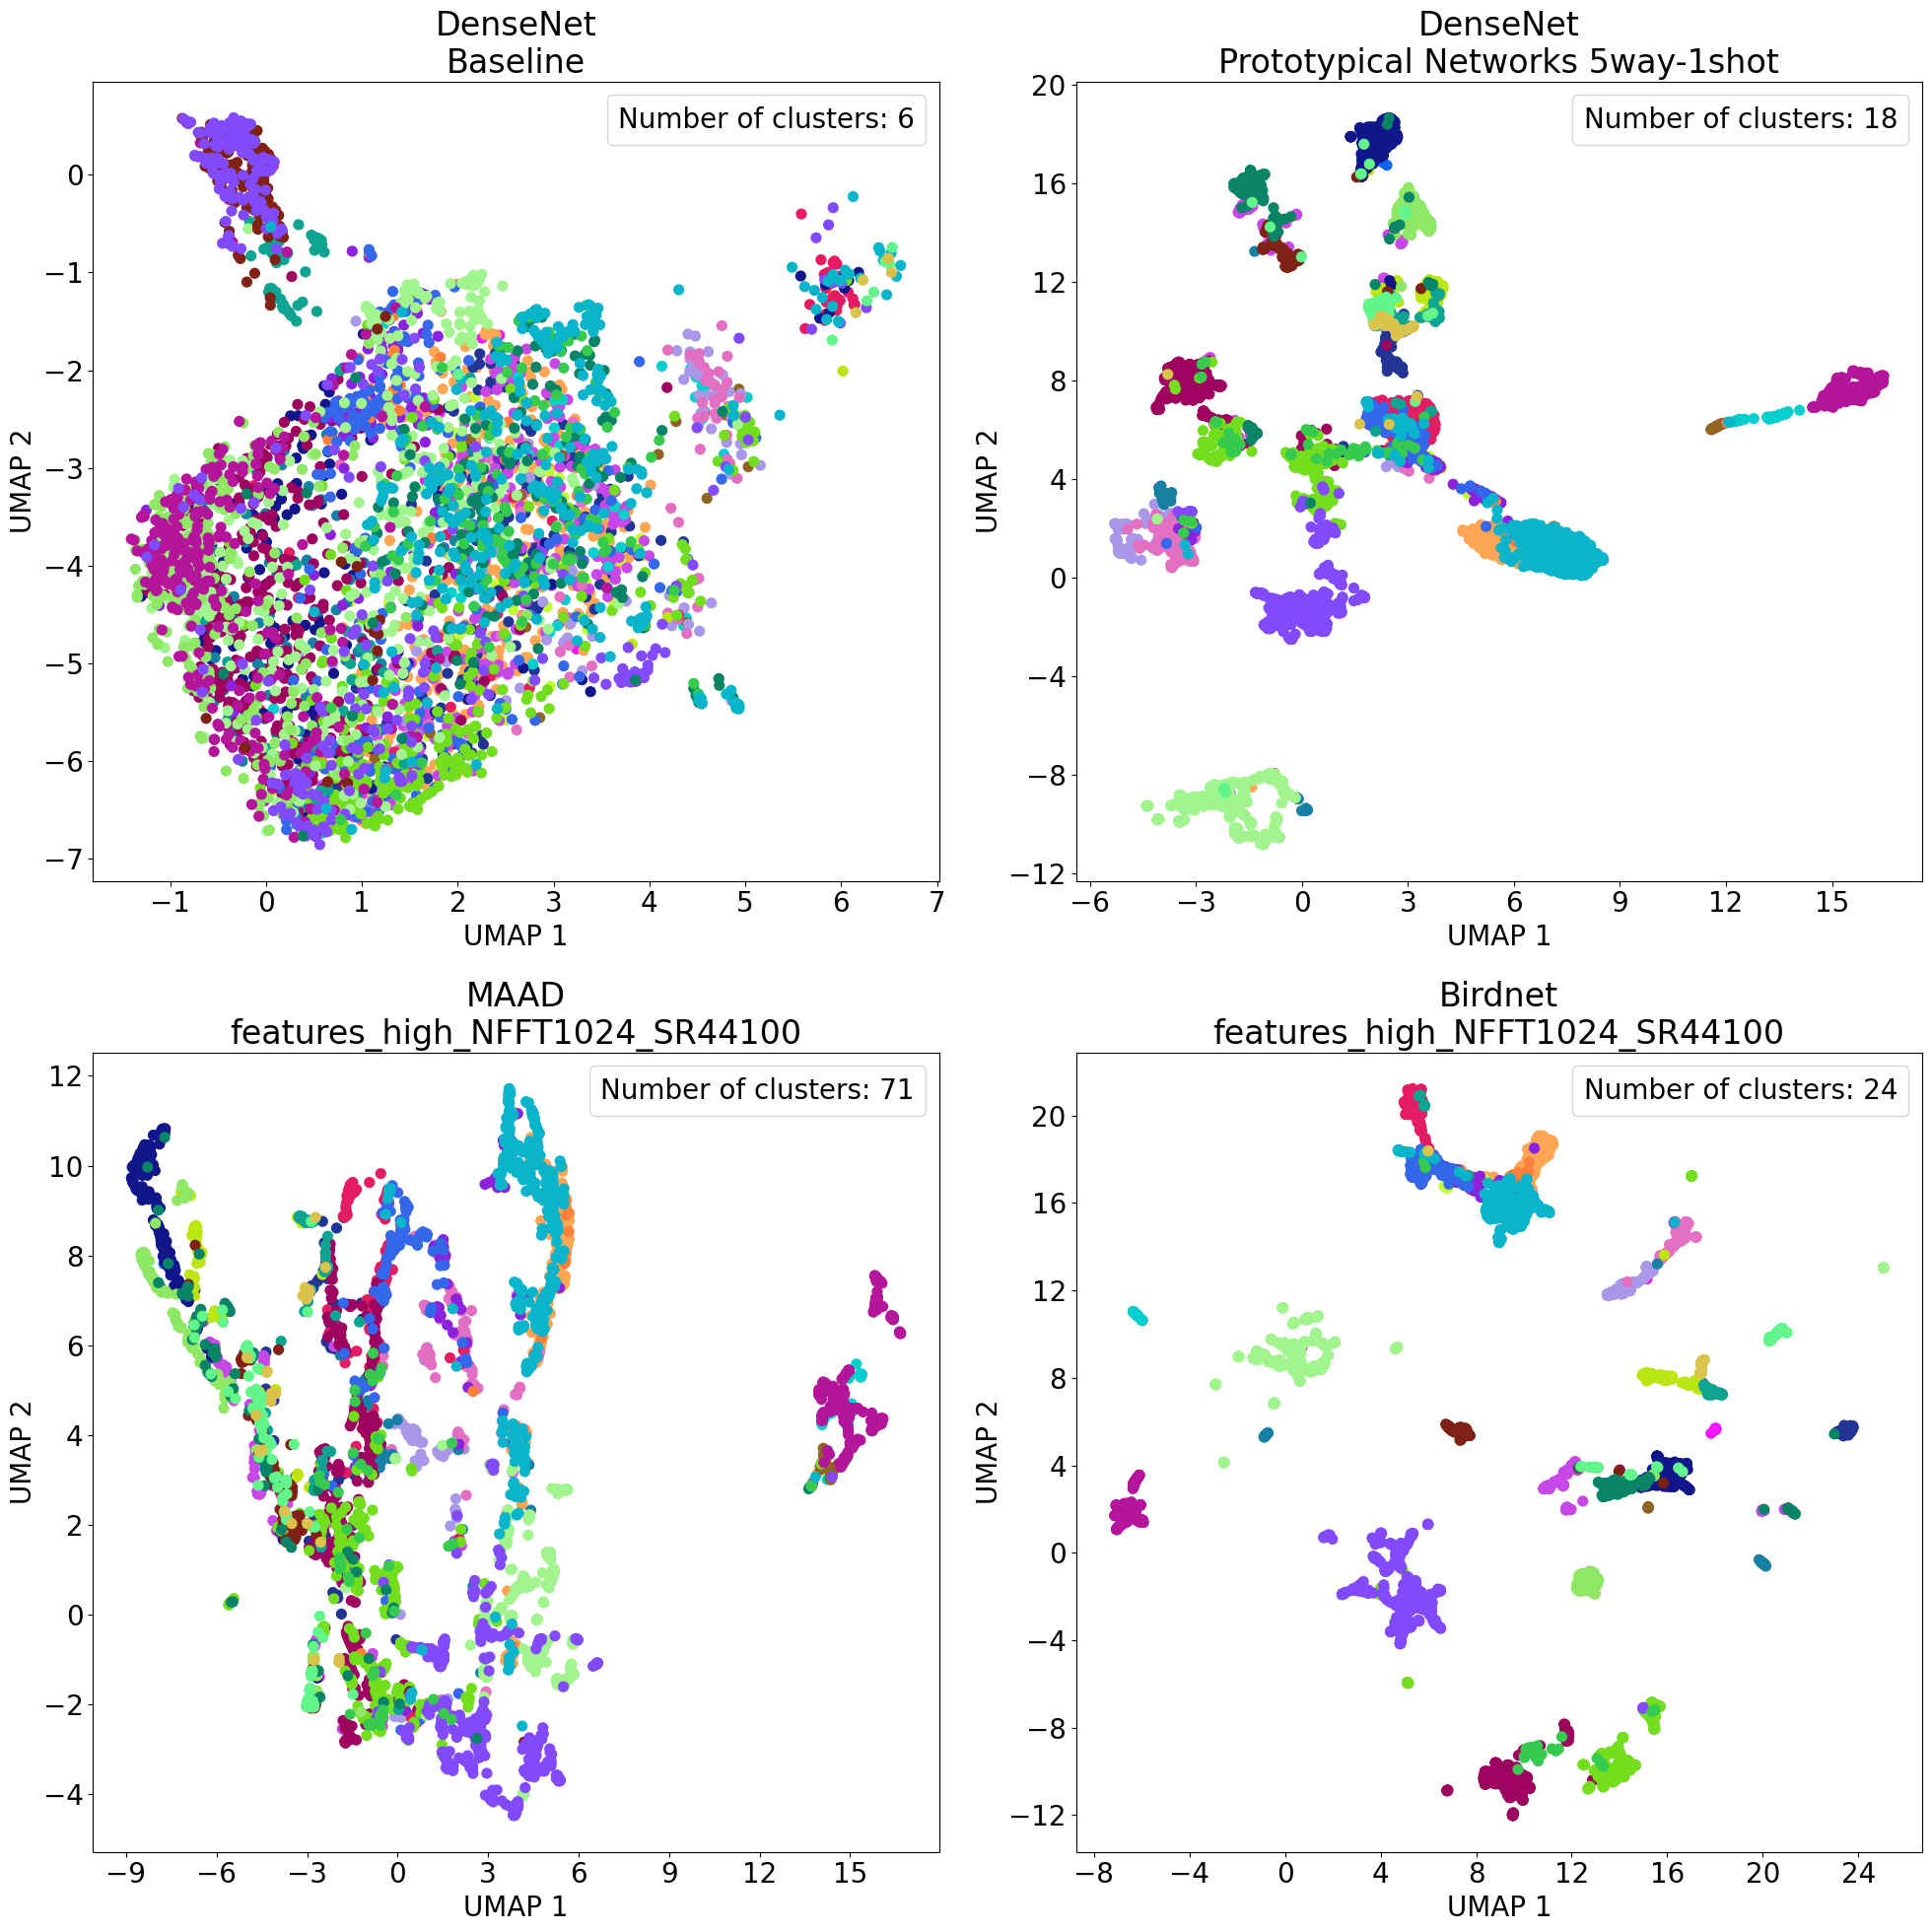

In [50]:
matplotlib.rcParams.update({'font.size': 20})
from matplotlib.ticker import MaxNLocator

# Load vector embeddings
baseline_labels, baseline_plot = plot_embedding(
                            f'{parent_path}//embeddings//features//baseline-densenet-30classes.npy', 
                            n_components=25,
                            method_reduc=METHOD_REDUC,
                            method_cluster=METHOD_CLUSTER,
                            random_seed=random_seed)
pn_labels, pn_plot = plot_embedding(
                            f'{parent_path}//embeddings//features//prototypical-networks-5way-1shot-densenet-30classes.npy',
                            n_components=50,
                            method_reduc=METHOD_REDUC,
                            method_cluster=METHOD_CLUSTER,
                            random_seed=random_seed)
maad_labels, maad_plot = plot_embedding(
                            f'{parent_path}//embeddings//features//{FEATURES_FILENAME}.npy',
                            n_components=20,
                            method_reduc=METHOD_REDUC,
                            method_cluster=METHOD_CLUSTER,
                            random_seed=random_seed)
birdnet_labels, birdnet_plot = plot_embedding(
                            f'{parent_path}//embeddings//features//birdnet.npy',
                            n_components=50,
                            method_reduc=METHOD_REDUC,
                            method_cluster=METHOD_CLUSTER,
                            random_seed=random_seed)
                            
# Create scatter plots
fig = plt.figure(figsize=(20, 20))
marker_size = 50

ax = fig.add_subplot(2, 2, 1)
ax.set_title('DenseNet\nBaseline')
ax.scatter(baseline_plot[baseline_labels >= 0].T[0], baseline_plot[baseline_labels >= 0].T[1], 
        s=marker_size, c=true_labels[baseline_labels >= 0],
        cmap=new_cmap, label=f'Number of clusters: {len(np.unique(baseline_labels))-1}') 
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True)
for item in leg.legendHandles:
    item.set_visible(False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax = fig.add_subplot(2, 2, 2)
ax.set_title('DenseNet\nPrototypical Networks 5way-1shot')
ax.scatter(pn_plot[pn_labels >= 0].T[0], pn_plot[pn_labels >= 0].T[1], 
        s=marker_size, c=true_labels[pn_labels >= 0],
        cmap=new_cmap, label=f'Number of clusters: {len(np.unique(pn_labels))-1}') 
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True)
for item in leg.legendHandles:
    item.set_visible(False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax = fig.add_subplot(2, 2, 3)
ax.set_title(f'MAAD\n{FEATURES_FILENAME}')
ax.scatter(maad_plot[maad_labels >= 0].T[0], maad_plot[maad_labels >= 0].T[1],
        s=marker_size, c=true_labels[maad_labels >= 0],
        cmap=new_cmap, label=f'Number of clusters: {len(np.unique(maad_labels))-1}')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True)
for item in leg.legendHandles:
    item.set_visible(False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax = fig.add_subplot(2, 2, 4)
ax.set_title(f'Birdnet\n{FEATURES_FILENAME}')
ax.scatter(birdnet_plot[birdnet_labels >= 0].T[0], birdnet_plot[birdnet_labels >= 0].T[1],
        s=marker_size, c=true_labels_birdnet[birdnet_labels >= 0],
        cmap=new_cmap, label=f'Number of clusters: {len(np.unique(birdnet_labels))-1}')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True)
for item in leg.legendHandles:
    item.set_visible(False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
# plt.savefig('plot.jpg', dpi=300);

## Explore the clusters

MEC is able to find clusters of sounds with good scores (Metric ARI and AMI). The number of clusters is close to expected number. However, a lot of ROIs does not belong to any cluster (ie noise) and the number of clusters as well as the metrics do not tell us :
* if all species belong to at least one cluster
* how many species belong to each cluster

In the following, we will :
* calculate and display the metrics
* show the species that belong to each cluster as well as the number of songs of each species
* find the species that do not belong to any clusters (ie all the bird songs are labeled as noise)
* find the most representative species for each cluster (ie the species with the highest number of bird songs in the cluster)
* find the species that are not the most representative species (ie the species that do not have the majority of bird songs in any clusters)

In [30]:
# #*************** Darksound 25 ***************
# load the features
# features = np.load(f'{parent_path}//embeddings//features//{MODEL_NAME}-30classes.npy')
# N_COMPONENTS = 25

# #*************** MAAD 22 ***************
# load the features
# features = np.load(f'{parent_path}//embeddings//features//{FEATURES_FILENAME}.npy')
# N_COMPONENTS = 22

# #*************** BIRDNET 25 ***************
# load the features from birdnet
features = np.load(f'{parent_path}//embeddings//features//birdnet.npy')
# separate the features from the true labels
true_labels_birdnet = np.load(f'{parent_path}//embeddings//features//birdnet_truelabel.npy')
true_labels = true_labels_birdnet
N_COMPONENTS = 25

# Find the clusters
clusterer, embedding = get_clusterer(
                    features=features, 
                    n_components=N_COMPONENTS, 
                    method_reduc=METHOD_REDUC, 
                    method_cluster=METHOD_CLUSTER, 
                    random_seed = random_seed)

# Get the predicted labels and the number of clusters
pseudo_labels = clusterer.labels_ 
clusters = len(np.unique(pseudo_labels[pseudo_labels >= 0])) # remove noisy samples
percentage = int(round(np.sum(pseudo_labels >= 0) / features.shape[0], 2) * 100)
print(f'\nClustering {percentage}% of the data: Found {clusters} clusters with n_components={N_COMPONENTS}.')

ari, ami, dbcv, dbcv_per_cluster = evaluation(embedding, true_labels, clusterer)
print(f'ARI: {ari}\nAMI: {ami}\nDBCV: {dbcv}\nDBCV_avg: {np.mean(dbcv_per_cluster)}\n')


Clustering 78% of the data: Found 49 clusters with n_components=25.
ARI: 0.7488726962875437
AMI: 0.8704055200239551
DBCV: 0.35576017871403337
DBCV_avg: 0.5011624511173607



In [31]:
# Get the list of tuples (file, label) for each species
species_files = test_set._flat_species_files
# Get the list of species
species = test_set._species
# Create a dictionary with the label as keys and the species as values
species_dict = {label: species for label, species in zip(np.unique(true_labels), species)}
#
print("Species found in the dataset:")
species_dict

Species found in the dataset:


{0: 'Chordeiles acutipennis_Lesser Nighthawk',
 1: 'Crypturellus soui_Little Tinamou',
 2: 'Nyctibius leucopterus_White-winged Potoo',
 3: 'Nyctibius griseus_Common Potoo',
 4: 'Strix huhula_Black-banded Owl',
 5: 'Hydropsalis cayennensis_White-tailed Nightjar',
 6: 'Hydropsalis climacocerca_Ladder-tailed Nightjar',
 7: 'Nyctiprogne leucopyga_Band-tailed Nighthawk',
 8: 'Lurocalis semitorquatus_Short-tailed Nighthawk',
 9: 'Chordeiles nacunda_Nacunda Nighthawk',
 10: 'Megascops watsonii_Tawny-bellied Screech Owl',
 11: 'Glaucidium hardyi_Amazonian Pygmy Owl',
 12: 'Lophostrix cristata_Crested Owl',
 13: 'Nyctipolus nigrescens_Blackish Nightjar',
 14: 'Micrastur semitorquatus_Collared Forest Falcon',
 15: 'Crypturellus variegatus_Variegated Tinamou',
 16: 'Crypturellus brevirostris_Rusty Tinamou',
 17: 'Tinamus major_Great Tinamou',
 18: 'Micrastur gilvicollis_Lined Forest Falcon',
 19: 'Megascops roraimae_Foothill Screech Owl',
 20: 'Nyctidromus albicollis_Pauraque',
 21: 'Pulsatrix pe

In [32]:
# For each cluster, print the species with the number of points per species
for pseudo_label_id in np.unique(pseudo_labels) :
    if pseudo_label_id != -1 :
        print(f'Cluster {pseudo_label_id} :')
        for true_label_id in np.unique(true_labels) :
            if np.sum((pseudo_labels == pseudo_label_id) & (true_labels == true_label_id)) > 0:
                print(f'    {species_dict[true_label_id]} : {np.sum((pseudo_labels == pseudo_label_id) & (true_labels == true_label_id))}')

Cluster 0 :
    Hydropsalis cayennensis_White-tailed Nightjar : 28
Cluster 1 :
    Hydropsalis cayennensis_White-tailed Nightjar : 59
Cluster 2 :
    Micrastur ruficollis_Barred Forest Falcon : 37
Cluster 3 :
    Nyctibius griseus_Common Potoo : 1
    Nyctibius grandis_Great Potoo : 130
Cluster 4 :
    Nyctibius griseus_Common Potoo : 167
    Strix virgata_Mottled Owl : 1
Cluster 5 :
    Strix huhula_Black-banded Owl : 1
    Megascops watsonii_Tawny-bellied Screech Owl : 1
    Pulsatrix perspicillata_Spectacled Owl : 261
Cluster 6 :
    Chordeiles acutipennis_Lesser Nighthawk : 23
    Nyctibius griseus_Common Potoo : 1
    Megascops watsonii_Tawny-bellied Screech Owl : 194
    Megascops roraimae_Foothill Screech Owl : 108
    Nyctibius bracteatus_Rufous Potoo : 57
Cluster 7 :
    Nyctipolus nigrescens_Blackish Nightjar : 30
Cluster 8 :
    Nyctidromus albicollis_Pauraque : 574
Cluster 9 :
    Micrastur semitorquatus_Collared Forest Falcon : 1
    Nyctibius aethereus_Long-tailed Potoo :

In [33]:
# Find the label in true_labels that are always equal to -1 in pseudo_labels
missing_species_any_cluster = []
for true_label_id in np.unique(true_labels) :
    if np.sum((pseudo_labels == -1) & (true_labels == true_label_id)) == np.sum((true_labels == true_label_id)) :
        missing_species_any_cluster.append(true_label_id)

print(f'{len(missing_species_any_cluster)} / {len(species_dict)} species are not present in any cluster.')

print("The list is:")
for nn in missing_species_any_cluster :
    print(f'    {species_dict[nn]}')

1 / 30 species are not present in any cluster.
The list is:
    Chordeiles nacunda_Nacunda Nighthawk


In [34]:
# list of labels corresponding to the most represented species in each cluster
label_to_cluster = []

# For each cluster, select the species with the most points and compute the percentage of points in the cluster
for pseudo_label_id in np.unique(pseudo_labels) :
    if pseudo_label_id != -1 :
        label_to_cluster += [np.unique(true_labels)[np.argmax([np.sum((pseudo_labels == pseudo_label_id) & (true_labels == true_label_id)) for true_label_id in np.unique(true_labels)])]]
        print(f'Cluster {pseudo_label_id} : {species_dict[label_to_cluster[-1]]} : {np.round(np.sum((pseudo_labels == pseudo_label_id) & (true_labels == label_to_cluster[-1])) / np.sum(pseudo_labels == pseudo_label_id) * 100).astype("int")}%')

Cluster 0 : Hydropsalis cayennensis_White-tailed Nightjar : 100%
Cluster 1 : Hydropsalis cayennensis_White-tailed Nightjar : 100%
Cluster 2 : Micrastur ruficollis_Barred Forest Falcon : 100%
Cluster 3 : Nyctibius grandis_Great Potoo : 99%
Cluster 4 : Nyctibius griseus_Common Potoo : 99%
Cluster 5 : Pulsatrix perspicillata_Spectacled Owl : 99%
Cluster 6 : Megascops watsonii_Tawny-bellied Screech Owl : 51%
Cluster 7 : Nyctipolus nigrescens_Blackish Nightjar : 100%
Cluster 8 : Nyctidromus albicollis_Pauraque : 100%
Cluster 9 : Nyctibius aethereus_Long-tailed Potoo : 99%
Cluster 10 : Nyctipolus nigrescens_Blackish Nightjar : 100%
Cluster 11 : Strix huhula_Black-banded Owl : 52%
Cluster 12 : Strix huhula_Black-banded Owl : 97%
Cluster 13 : Hydropsalis maculicaudus_Spot-tailed Nightjar : 100%
Cluster 14 : Hydropsalis maculicaudus_Spot-tailed Nightjar : 100%
Cluster 15 : Hydropsalis climacocerca_Ladder-tailed Nightjar : 100%
Cluster 16 : Nyctiprogne leucopyga_Band-tailed Nighthawk : 99%
Clust

In [35]:
# list of species that are not the most represented in any cluster
missing_species_as_main_cluster = np.setdiff1d(np.unique(true_labels), label_to_cluster)

print(f'{len(missing_species_as_main_cluster)} / {len(species_dict)} species are not representing by a cluster.')

print("The list is:")
for label in missing_species_as_main_cluster :
    print(f'    {species_dict[label]}')

6 / 30 species are not representing by a cluster.
The list is:
    Chordeiles acutipennis_Lesser Nighthawk
    Chordeiles nacunda_Nacunda Nighthawk
    Crypturellus variegatus_Variegated Tinamou
    Crypturellus brevirostris_Rusty Tinamou
    Megascops roraimae_Foothill Screech Owl
    Nyctibius bracteatus_Rufous Potoo


In [36]:
# for each species in the list missing_species_as_main_cluster, find the clusters where they are present
# and the percentage of points that they represent from the total number of points of the species
for label in missing_species_as_main_cluster :
    print(f'{species_dict[label]} :')
    for pseudo_label_id in np.unique(pseudo_labels) :
        if pseudo_label_id != -1 :
            if np.sum((pseudo_labels == pseudo_label_id) & (true_labels == label)) > 0:
                print(f'    Cluster {pseudo_label_id} : {np.round(np.sum((pseudo_labels == pseudo_label_id) & (true_labels == label)) / np.sum(true_labels == label) * 100).astype("int")}%')
    # print the sum of the percentage of points that the species represent in the clusters
    print(f'    Total : {np.round(np.sum([np.sum((pseudo_labels == pseudo_label_id) & (true_labels == label)) / np.sum(true_labels == label) * 100 for pseudo_label_id in np.unique(pseudo_labels) if pseudo_label_id != -1])).astype("int")}%')


Chordeiles acutipennis_Lesser Nighthawk :
    Cluster 6 : 77%
    Total : 77%
Chordeiles nacunda_Nacunda Nighthawk :
    Total : 0%
Crypturellus variegatus_Variegated Tinamou :
    Cluster 19 : 1%
    Cluster 43 : 1%
    Cluster 44 : 2%
    Cluster 48 : 31%
    Total : 34%
Crypturellus brevirostris_Rusty Tinamou :
    Cluster 48 : 57%
    Total : 57%
Megascops roraimae_Foothill Screech Owl :
    Cluster 6 : 95%
    Total : 95%
Nyctibius bracteatus_Rufous Potoo :
    Cluster 6 : 97%
    Total : 97%
